# Eligibility traces

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import gym
rng = np.random.default_rng()
import time
from IPython.display import clear_output

def running_average(x, N):
    cumsum = np.cumsum(np.insert(np.array(x), 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N

## Q-learning

### Interaction with the environment

The goal of this exercise is to solve the **Gridworld** problem using Q-learning. The code is adapted from  <https://github.com/rlcode/reinforcement-learning-kr>

The agent is represented by the red square: the **state** $s$ of the agent is its position in the 5x5 grid, i.e. a number between 0 and 24.

The agent can move either to the left, right, top or bottom. When the agent tries to move outside of the environment, it stays at its current position. There are four **actions** $a$ available, which are deterministic.    

Its goal is to reach the blue circle, while avoiding the green triangles. Actions leading to the blue circle receive a reward $r$ of +100, actions leading to a green triangle receive a reward of -100. The episode ends in those states. All other actions have a reward of -1.

The following code allows you to run a **random agent** in this environment for maximally 1000 episodes: at each time step, the action is selected randomly between 0 and 3 with `env.action_space.sample()`.

The graphical interface and the dynamics of the environment are implemented in the file `Gridworld.py`. You do not have to read the file (but you can if you want...). It follows mainly the API of the `gym` library.

The environment is created with:

```python
env = Gridworld(size, rewards)
```

`size` is the number of cells in the environment (here `(5, 5)`). `rewards` define the rewards received when hitting a blue circle, a green triangle or the default, respectively.

`env.render()` allows to create and/or refresh the GUI. If you pass it a Q-table (`env.render(q_table)`), it will print the Q_value of each action at the corresponding location.

`state = env.reset()` allows to start an episode. The agent is placed at the top-left of the grid (`state = 0`). 

`next_state, reward, done, info = env.step(action)` allows to perform an action on the environment. `action` must be a number between 0 and 3. It return the next state, the reward received during the transition, as well as a boolean `done` which is `True` when the episode is terminated (the agent moved to a blue circle or a green triangle), `False` otherwise. `info` is also a boolean, which is set to True when you close the window, 

**Q:** Understand and run the code. Does the agent succeed often? How complex is the task compared to Taxi?

In [13]:
class GridWorld(gym.Env):
    
    def __init__(self, rewards=[100, -100, -1], size=5):
        "Initialize the environment, can accept additional parameters such as the number of states and actions."
        
        self.size = size
        self.rewards = rewards
        
        # State space
        self.observation_space = gym.spaces.Discrete(self.size**2)
        
        # Action space
        self.action_space = gym.spaces.Discrete(4)    
        
        super().__init__()
        
        self.state = self.reset()
        self.t_max = 100
        
        self.target = (3, 2)
        self.distractor1 = (2, 2)
        self.distractor2 = (3, 3)
    
    def reset(self):
        "Resets the environment and starts from an initial state."
        
        # Sample one state randomly 
        self.state = self.rank((0, self.size-1))
        self._t = 0
        self.sum_rewards = 0.0
        
        return self.state
    
    def step(self, action):
        """
        Takes an action and returns a new state, a reward, a boolean (True for terminal states) 
        and a dictionary with additional info (optional).
        """
        self._t +=1
        self.done = False
        
        x, y = self.coordinates(self.state)
        if action == 0: # up
            y = max(min(y + 1, self.size-1), 0)
        elif action == 1: # down
            y = max(min(y - 1, self.size-1), 0)
        elif action == 2: # left
            x = max(min(x - 1, self.size-1), 0)
        elif action == 3: # right
            x = max(min(x + 1, self.size-1), 0)
        
        self.state = self.rank((x, y))
        
        if self.state == self.rank(self.target):
            self.reward = self.rewards[0]
            self.done = True
        elif self.state == self.rank(self.distractor1) or self.state == self.rank(self.distractor2):
            self.reward = self.rewards[1]
            self.done = True
        else:
            self.reward = self.rewards[2]
            
        if self._t >= self.t_max:
            self.done = True
            
        self.sum_rewards += self.reward
        self.info = {'return': self.sum_rewards}
        
        return self.state, self.reward, self.done, self.info

    def render(self, Q):
        "Displays the current state of the environment."
        
        plt.figure(figsize=(10, 10))
        
        # grid
        for i in range(1, self.size):
            plt.plot([i, i], [0, self.size], color="black")
        for i in range(1, self.size):
            plt.plot([0, self.size], [i, i], color="black")
            
        # Q-values
        for s in range(self.size*self.size):
            c = self.coordinates(s)
            plt.text(c[0] + 0.5, c[1] + 0.9, f"{Q[s, 0]:.2f}", horizontalalignment='center', verticalalignment='center')
            plt.text(c[0] + 0.5, c[1] + 0.1, f"{Q[s, 1]:.2f}", horizontalalignment='center', verticalalignment='center')
            plt.text(c[0] + 0.05, c[1] + 0.5, f"{Q[s, 2]:.2f}", horizontalalignment='left', verticalalignment='center')
            plt.text(c[0] + 0.95, c[1] + 0.5, f"{Q[s, 3]:.2f}", horizontalalignment='right', verticalalignment='center')
            
        # target
        plt.scatter([self.target[0] +0.5], [self.target[1] + 0.5], s=5000, marker="o", color="blue")
        plt.scatter([self.distractor1[0] +0.5], [self.distractor1[1] + 0.5], s=5000, marker="^", color="green")
        plt.scatter([self.distractor2[0] +0.5], [self.distractor2[1] + 0.5], s=5000, marker="^", color="green")
        
        # state
        s = self.coordinates(self.state)
        plt.scatter([s[0] + 0.5], [s[1] + 0.5], s=5000, marker="s", color="red")
        
        plt.xticks([])
        plt.yticks([])
        plt.xlim((0, self.size))
        plt.ylim((0, self.size))
        plt.title("Step " + str(self._t) + " - undiscounted return " + str(self.sum_rewards))
        
        clear_output(wait=True)
        plt.show()
    
    def coordinates(self, state):
        "Returns coordinates of a state."
        return (state % self.size, int(state/self.size))
    
    def rank(self, coord):
        "Returns rank from coordinates."
        return coord[0] + self.size*coord[1]
    

In [26]:
class RandomAgent:
    
    def __init__(self, env):
        self.env = env
        self.Q = np.zeros((self.env.observation_space.n, self.env.action_space.n))
        
    def act(self, state):
        "Selects an action randomly"
        return self.env.action_space.sample()
    
    def train(self, nb_episodes, render=True):
        "Runs the agent on the environment for nb_episodes. Returns the list of obtained returns."

        # Returns
        returns = []

        # Fixed number of episodes
        for episode in range(nb_episodes):

            # Reset
            state = self.env.reset()
            done = False
            nb_steps = 0

            # Store rewards
            rewards = []

            # Sample the episode
            while not done:
                
                # Render the current state
                if render:
                    clear_output(wait=True)
                    self.env.render(self.Q)
                    time.sleep(0.1)

                # Select an action 
                action = self.act(state)

                # Perform the action
                next_state, reward, done, info = self.env.step(action)
                
                # Append reward
                rewards.append(reward)

                # Go in the next state
                state = next_state

                # Increment time
                nb_steps += 1
                
                if done: 
                    clear_output(wait=True)
                    self.env.render(self.Q)

            # Compute the discounted return of the episode.
            return_episode = np.sum(rewards)    

            # Store info
            returns.append(return_episode)
            
        return returns

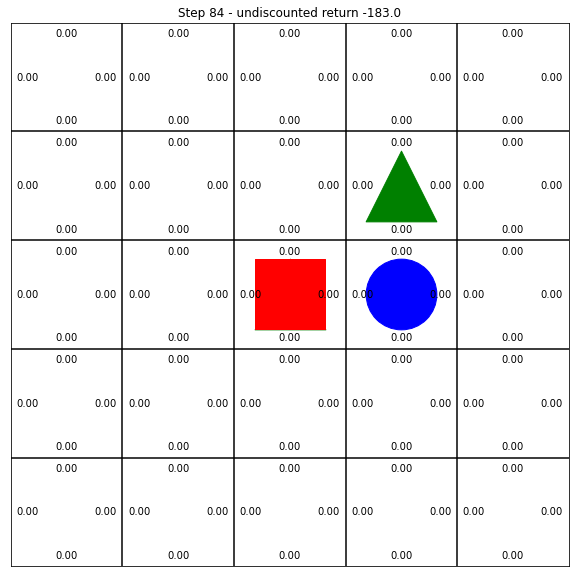

[-183]


In [27]:
# Create the environment
env = GridWorld()

# Create the agent
agent = RandomAgent(env)

returns = agent.train(1, render=True)
        
print(returns)

In [34]:
class QLearningAgent:
    """
    Q-learning agent.
    """
    
    def __init__(self, env, gamma, epsilon, decay_epsilon, alpha):
        """
        :param env: gym-like environment
        :param gamma: discount factor
        :param epsilon: exploration parameter
        :param decay_epsilon: exploration decay parameter
        :param alpha: learning rate
        """
        self.env = env
        self.gamma = gamma
        self.epsilon = epsilon
        self.decay_epsilon = decay_epsilon
        self.alpha = alpha
        
        # Q_table
        self.Q = np.zeros([self.env.observation_space.n, self.env.action_space.n])
    
    def act(self, state):
        "Returns an action using epsilon-greedy action selection."
        
        action = rng.choice(np.where(self.Q[state, :] == self.Q[state, :].max())[0])
        
        if rng.random() < self.epsilon:
            action = self.env.action_space.sample() 
        
        return action
    
    def update(self, state, action, reward, next_state, done):
        "Updates the agent using a single transition."
        
        # Bellman target
        target = reward
        
        if not done:
            target += self.gamma * self.Q[next_state, :].max()
        
        # Update the Q-value
        self.Q[state, action] += self.alpha * (target - self.Q[state, action])
            
        # Decay epsilon
        self.epsilon = self.epsilon * (1 - self.decay_epsilon)
            
    
    def train(self, nb_episodes, render=True):
        "Runs the agent on the environment for nb_episodes. Returns the list of obtained returns."

        # Returns
        returns = []

        # Fixed number of episodes
        for episode in range(nb_episodes):

            # Reset
            state = self.env.reset()
            done = False
            nb_steps = 0

            # Store rewards
            rewards = []

            # Sample the episode
            while not done:
                
                # Render the current state
                if render:
                    clear_output(wait=True)
                    self.env.render(self.Q)
                    time.sleep(0.01)

                # Select an action 
                action = self.act(state)

                # Perform the action
                next_state, reward, done, info = self.env.step(action)
                
                # Append reward
                rewards.append(reward)

                # Learn from the transition
                self.update(state, action, reward, next_state, done)

                # Go in the next state
                state = next_state

                # Increment time
                nb_steps += 1
                
                if done: 
                    clear_output(wait=True)
                    self.env.render(self.Q)

            # Compute the discounted return of the episode.
            return_episode = self.discounted_return(rewards)    

            # Store info
            returns.append(return_episode)
            
        return returns
    
    def test(self, render=True):
        "Performs a test episode without exploration."
        previous_epsilon = self.epsilon
        self.epsilon = 0.0
        
        # Reset
        state = self.env.reset()
        done = False
        nb_steps = 0
        rewards= 0

        # Sample the episode
        while not done:
            if render:
                clear_output(wait=True)
                self.env.render(self.Q)
                time.sleep(0.05)
            action = self.act(state)
            next_state, reward, done, info = self.env.step(action)
            rewards += reward
            state = next_state
            nb_steps += 1
            
        self.epsilon = previous_epsilon
            
        return rewards, nb_steps
    
    def discounted_return(self, rewards):
        "Computes the discounted return of an episode based on the list of rewards."
        ret = 0.0
        for reward in reversed(rewards):
            ret = reward + self.gamma*ret
        return ret

In [35]:
# Parameters
gamma = 0.99
epsilon = 0.1
decay_epsilon = 0
alpha = 0.1
nb_episodes = 50

# Create the environment
env = GridWorld(rewards=[100, -100, -1])

# Create the agent
agent = QLearningAgent(env, gamma, epsilon, decay_epsilon, alpha)

# Train the agent for 200 episodes
returns = agent.train(nb_episodes, render=True)

print(returns)

KeyboardInterrupt: 

**Q:** Modify your agent so that it uses **softmax action selection**, with a temperature $\tau = 1.0$. What does it change?

If you have time, write a generic class for the Q-learning agent where you can select the action selection method flexibly.

In [ ]:
class QLearningAgent:
    
    def __init__(self, env, gamma, action_selection, alpha):
        # Store data
        self.env = env
        self.gamma = gamma
        self.action_selection = action_selection
        self.alpha = alpha
        
        # Q_table
        self.q_table = np.zeros([self.env.observation_space.n, self.env.action_space.n])
        
    def act(self, state):
        
        if self.action_selection['type'] == "egreedy":
            # epsilon-greedy
            if np.random.uniform(0, 1, 1) < self.action_selection['epsilon']:
                action = self.env.action_space.sample() 
            else:
                action = np.random.choice(np.where(self.q_table[state, :] == self.q_table[state, :].max())[0])
        else: # softmax
            logits = np.exp((self.q_table[state, :] - self.q_table[state, :].max())/self.action_selection['tau'])
            probas = logits / np.sum(logits)
            action = np.random.choice(range(4), p=probas) 
            
        return action
    
    def update(self, state, action, reward, next_state, done):
        
        # Bellman target
        target = reward
        if not done:
            target += self.gamma * self.q_table[next_state, :].max()
        
        # Update the Q-value
        self.q_table[state, action] += self.alpha * (target - self.q_table[state, action])
            
        # Decay exploration parameters
        if self.action_selection['type'] == "egreedy":
            self.action_selection['epsilon'] = self.action_selection['epsilon'] * (1 - self.action_selection['decay'])
        else:
            self.action_selection['tau'] = self.action_selection['tau'] * (1 - self.action_selection['decay'])
        
    
    def train(self, nb_episodes):
        
        # Returns
        training_returns = []
        test_returns = []

        # Fixed number of episodes
        for episode in range(nb_episodes):

            # Reset
            state = self.env.reset()
            done = False
            nb_steps = 0

            # Store rewards
            rewards = []

            # Sample the episode
            while not done:
                
                # Render
                self.env.render(self.q_table)

                # Select an action 
                action = self.act(state)

                # Perform the action
                next_state, reward, done, info = self.env.step(action)

                # Store the reward
                rewards.append(reward)
                
                # Update the Q-learning agent
                self.update(state, action, reward, next_state, done)   

                # Go in the next state
                state = next_state

                # Increment time
                nb_steps += 1
                
            if info: # GUI closed
                print("Done")
                self.env.close()
                break
 
            # Store info
            return_episode = self.discounted_return(rewards)
            training_returns.append(return_episode)
                
        self.env.close()
        return training_returns
    
    def discounted_return(self, rewards):
        "Computes the discounted return from the list of rewards"
        ret = 0.0
        for reward in reversed(rewards):
            ret = reward + self.gamma*ret
        return ret

In [ ]:
# Parameters
gamma = 0.99
#action_selection  = {'type': "egreedy", "epsilon": 0.1, "decay": 0.0}
action_selection  = {'type': "softmax", "tau": 1.0, "decay": 0.0}
alpha = 0.1
nb_episodes = 200

# Create the environment
env = Gridworld()

# Create the agent
agent = QLearningAgent(env, gamma, action_selection, alpha)

# Train the agent for 200 episodes
training_returns = agent.train(nb_episodes)

In [ ]:
# Plot the returns
plt.plot(training_returns, label="Training")
plt.plot(running_mean(training_returns, 10), label="Training (smoothed)")
plt.legend()
plt.xlabel("Episodes")
plt.ylabel("Returns")
plt.show()

**Answer:** The agent explores much less at the end of training, as the difference between the Q-values becomes high enough to become greedy. there is no real need to decay tau.

## 2 - Eligibility traces

The main drawback of Q-learning is that it needs many episodes to converge (**sample complexity**).

One way to speed up learning is to use eligibility traces, one per state-action pair:

```python
traces = np.zeros((nb_states, nb_actions))
```

After each transition $(s_t, a_t)$, Q($\lambda$) updates a **trace** $e(s_t, a_t)$ and modifies all Q-values as:

1.  The trace of the last transition is incremented from 1:
    
$$e(s_t, a_t) = e(s_t, a_t) +1$$
    
2. Q($\lambda$)-learning is applied on **ALL** Q-values, using the TD error at time $t$:
    
$$Q(s, a) = Q(s, a) + \alpha \, (r_{t+1} + \gamma \, \max_{a'} Q(s_{t+1}, a') - Q(s_t, a_t)) \, e(s, a)$$
    
3. All traces are exponentially decreased using the trace parameter $\lambda$ (e.g. 0.7):

$$
e(s, a) = \lambda \, \gamma \, e(s, a)
$$

All traces are reset to 0 at the beginning of an episode.

**Q9:** Implement eligibility traces in your Q($\lambda$)-learning agent and see if it improves convergence.

In [ ]:
class QLambdaLearningAgent:
    
    def __init__(self, env, gamma, lbda, action_selection, alpha):
        # Store data
        self.env = env
        self.gamma = gamma
        self.lbda = lbda
        self.action_selection = action_selection
        self.alpha = alpha
        
        # Q_table
        self.q_table = np.zeros([self.env.observation_space.n, self.env.action_space.n])
        self.traces = np.zeros([self.env.observation_space.n, self.env.action_space.n])
        
    def act(self, state):
        
        if self.action_selection['type'] == "egreedy":
            # epsilon-greedy
            if np.random.uniform(0, 1, 1) < self.action_selection['epsilon']:
                action = self.env.action_space.sample() 
            else:
                action = np.random.choice(np.where(self.q_table[state, :] == self.q_table[state, :].max())[0])
        else: # softmax
            logits = np.exp((self.q_table[state, :] - self.q_table[state, :].max())/self.action_selection['tau'])
            probas = logits / np.sum(logits)
            action = np.random.choice(range(4), p=probas) 
            
        return action
    
    def update(self, state, action, reward, next_state, done):
        
        # Bellman target
        target = reward
        if not done:
            target += self.gamma * self.q_table[next_state, :].max()
        
        # Update ALL Q-values
        self.q_table += self.alpha * (target - self.q_table[state, action]) * self.traces
            
        # Decay exploration parameters
        if self.action_selection['type'] == "egreedy":
            self.action_selection['epsilon'] = self.action_selection['epsilon'] * (1 - self.action_selection['decay'])
        else:
            self.action_selection['tau'] = self.action_selection['tau'] * (1 - self.action_selection['decay'])
        
    
    def train(self, nb_episodes):
        
        # Returns
        training_returns = []
        test_returns = []

        # Fixed number of episodes
        for episode in range(nb_episodes):

            # Reset
            state = self.env.reset()
            done = False
            nb_steps = 0
            
            # Reset traces
            self.traces *= 0

            # Store rewards
            rewards = []

            # Sample the episode
            while not done:
                
                # Render
                self.env.render(self.q_table)

                # Select an action 
                action = self.act(state)

                # Perform the action
                next_state, reward, done, info = self.env.step(action)

                # Store the reward
                rewards.append(reward)
                
                # Increment trace
                self.traces[state, action] += 1
                
                # Update the Q-learning agent
                self.update(state, action, reward, next_state, done)   
                
                # Update all traces
                self.traces *= self.gamma * self.lbda

                # Go in the next state
                state = next_state

                # Increment time
                nb_steps += 1
                
            if info: # GUI closed
                print("Done")
                self.env.close()
                break
 
            # Store info
            return_episode = self.discounted_return(rewards)
            training_returns.append(return_episode)
                
        self.env.close()
        return training_returns
    
    def discounted_return(self, rewards):
        "Computes the discounted return from the list of rewards"
        ret = 0.0
        for reward in reversed(rewards):
            ret = reward + self.gamma*ret
        return ret

In [ ]:
# Parameters
gamma = 0.99
lbda = 0.7
#action_selection  = {'type': "egreedy", "epsilon": 0.1, "decay": 0.0}
action_selection  = {'type': "softmax", "tau": 1.0, "decay": 0.0}
alpha = 0.1
nb_episodes = 200

# Create the environment
from Gridworld import Gridworld
env = Gridworld(size=(5, 5), rewards=[100, -100, -1])

# Create the agent
agent = QLambdaLearningAgent(env, gamma, lbda, action_selection, alpha)

# Train the agent for 200 episodes
training_returns = agent.train(nb_episodes)

In [ ]:
# Plot the returns
plt.plot(training_returns, label="Training")
plt.plot(running_mean(training_returns, 10), label="Training (smoothed)")
plt.legend()
plt.xlabel("Episodes")
plt.ylabel("Returns")
plt.show()

**Q:** Vary the decay parameter $\lambda$ and discuss its influence.

**Q:** Increase the size of Gridworld to 10x10 and observe how long it takes to learn the optimal strategy.

```python
size = (10, 10)
```

*Note:* do not change it to anything else than square (i.e. not (10, 5)). There is a bug... If you find it and report it, you win a cookie.

Comment on the **curse of dimensionality** and the interest of tabular RL for complex tasks with large state spaces and sparse rewards (e.g. robotics).

In [ ]:
# Parameters
gamma = 0.99
lbda = 0.7
#action_selection  = {'type': "egreedy", "epsilon": 0.1, "decay": 0.0}
action_selection  = {'type': "softmax", "tau": 1.0, "decay": 0.0}
alpha = 0.1
nb_episodes = 200

# Create the environment
from Gridworld import Gridworld
env = Gridworld(size=(10, 10), rewards=[100, -100, -1])

# Create the agent
agent = QLambdaLearningAgent(env, gamma, lbda, action_selection, alpha)

# Train the agent for 200 episodes
training_returns = agent.train(nb_episodes)